# **Twitter Sentiment Classifier**
**Author:** Yusra Shereen (K259003)

This notebook trains and evaluates a **3-class sentiment classifier** on a Twitter dataset (`clean_text`, `category` with values `-1`, `0`, `1`).

**How to run on Colab**
1. Upload `Twitter_Data.csv` to Colab (Files panel) or mount Google Drive and point `DATA_PATH` accordingly.
2. Run cells top-to-bottom. The notebook will produce:
   - `misclassified_examples.csv`
   - Saved model weights and vectorizers in `twitter_sentiment_results/`


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Install required packages
# !pip install -q pandas numpy scikit-learn matplotlib seaborn reportlab nbformat

import os, re, random, json
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
RANDOM_SEED = 24
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

OUTDIR = '/content/drive/MyDrive/Fall2025/NLP/SentimentAnalysisAssignment/twitter_sentiment_results_31OCT2025_2'
os.makedirs(OUTDIR, exist_ok=True)

DATA_PATH = '/content/drive/MyDrive/Fall2025/NLP/SentimentAnalysisAssignment/Twitter_Data.csv'


In [3]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

# **Data Pre-processing**

In [4]:
df = pd.read_csv(DATA_PATH)
print('Initial shape:', df.shape)

# Drop rows with missing category and basic cleaning
df = df.dropna(subset=['category']).copy()
df['clean_text'] = df['clean_text'].astype(str)

# map labels {-1.0, 0.0, 1.0} -> {0,1,2}
label_map = {-1.0:0, 0.0:1, 1.0:2}
df['y'] = df['category'].astype(float).map(label_map).astype(int)

# Basic cleaning function with simple negation handling
URL_RE = re.compile(r'http\S+|www\.\S+')
MENTION_RE = re.compile(r'@\w+')
NEGATION_RE = re.compile(r'\b(not|no|n\'t|never)\b') # Simple negation list

def basic_clean(text):
    text = str(text).lower().strip()
    text = URL_RE.sub(' ', text)
    text = MENTION_RE.sub(' ', text)
    #add _not to the next word
    text = NEGATION_RE.sub(r'\1_NOT', text)
    text = re.sub(r'[^a-z0-9\s_]', ' ', text) # negation
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['text'] = df['clean_text'].map(basic_clean)
df = df[['text','y']].dropna().reset_index(drop=True)
print('After cleaning shape:', df.shape)
print(df['y'].value_counts())

# NEW FEATURES
# Word count
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Simple +ve and -ve lexicons
positive_lexicon = set(['good', 'great', 'excellent', 'awesome', 'positive', 'happy', 'love', 'best', 'success', 'win', 'like', 'amazing'])
negative_lexicon = set(['bad', 'poor', 'terrible', 'awful', 'negative', 'sad', 'hate', 'worst', 'fail', 'lose', 'dislike', 'horrible'])

# Add negated versions to lexicons for basic negation handling
positive_lexicon_negated = set([word + '_NOT' for word in positive_lexicon])
negative_lexicon_negated = set([word + '_NOT' for word in negative_lexicon])

# LemmatizatioN
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN) # Default to Noun if tag not found

def lemmatize_text(text):
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in words]
    return ' '.join(lemmatized_words)

df['lemmatized_text'] = df['text'].apply(lemmatize_text)

# Positive and negative lexicon word counts on lemmatized text
def count_lexicon_words_lemmatized(text, lexicon, negated_lexicon):
    words = text.split()
    count = 0
    for word in words:
        # word and its lemmatized form in lexicons
        lemmatized_word = lemmatizer.lemmatize(word, get_wordnet_pos(word))
        if word in lexicon or lemmatized_word in lexicon:
            count += 1
        elif word in negated_lexicon or lemmatized_word in negated_lexicon:
            count -= 1 # decrement for negated +ve words / increment for negated -ve words
    return count

df['positive_score_lemma'] = df['lemmatized_text'].apply(lambda x: count_lexicon_words_lemmatized(x, positive_lexicon, negative_lexicon_negated)) # count +ve words and negated -ve words
df['negative_score_lemma'] = df['lemmatized_text'].apply(lambda x: count_lexicon_words_lemmatized(x, negative_lexicon, positive_lexicon_negated)) # count -ve words and negated +ve words

# Simple sentiment score
df['sentiment_score_lemma'] = df['positive_score_lemma'] - df['negative_score_lemma']


print('\nExamples with new features:')
print(df.sample(5, random_state=RANDOM_SEED))

Initial shape: (162980, 2)
After cleaning shape: (162973, 2)
y
2    72250
1    55213
0    35510
Name: count, dtype: int64


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!



Examples with new features:
                                                     text  y  word_count  \
125506  modi says proud our soldier who fought for the...  2          42   
117927  always for common man opposite modi called cho...  0          23   
18067   yes you are right the way opposition demands a...  2          18   
46422   congratulations india become super power space...  2          11   
13919   james bond india how come find bjp leaders cat...  0          20   

                                          lemmatized_text  \
125506  modi say proud our soldier who fought for the ...   
117927  always for common man opposite modi call chowk...   
18067   yes you be right the way opposition demand acc...   
46422   congratulation india become super power space ...   
13919   james bond india how come find bjp leader catc...   

        positive_score_lemma  negative_score_lemma  sentiment_score_lemma  
125506                     0                     0                     

In [5]:
df.head()

,text,y,word_count,lemmatized_text,positive_score_lemma,negative_score_lemma,sentiment_score_lemma
0,when modi promised minimum government maximum ...,0,33,when modi promise minimum government maximum g...,0,0,0
1,talk all the nonsense and continue all the dra...,1,13,talk all the nonsense and continue all the dra...,0,0,0
2,what did just say vote for modi welcome bjp to...,2,22,what do just say vote for modi welcome bjp tol...,0,0,0
3,asking his supporters prefix chowkidar their n...,2,34,ask his supporter prefix chowkidar their name ...,1,0,1
4,answer who among these the most powerful world...,2,14,answer who among these the most powerful world...,0,0,0


In [6]:
# ~70% train, 10% val, 20% test
# Include the new features in the feature set X
feature_cols = ['text', 'lemmatized_text','word_count','positive_score_lemma','negative_score_lemma','sentiment_score_lemma']
X = df[feature_cols]
y = df['y']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=RANDOM_SEED, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=2/3, random_state=RANDOM_SEED, stratify=y_temp)

print('Sizes ->', len(X_train), len(X_val), len(X_test))
print('X_train columns:', X_train.columns)

Sizes -> 114081 16297 32595
X_train columns: Index(['text', 'lemmatized_text', 'word_count', 'positive_score_lemma',
       'negative_score_lemma', 'sentiment_score_lemma'],
      dtype='object')


In [7]:
# Check for -ve values in numerical features
numerical_features = ['word_count','positive_score_lemma','negative_score_lemma','sentiment_score_lemma']
print("Negative value counts per numerical feature in X_train:")
for feature in numerical_features:
    if feature in X_train.columns:
        negative_count = (X_train[feature] < 0).sum()
        print(f"  {feature}: {negative_count}")
    else:
        print(f"  Feature '{feature}' not found in X_train.")

Negative value counts per numerical feature in X_train:
  word_count: 0
  positive_score_lemma: 0
  negative_score_lemma: 0
  sentiment_score_lemma: 6528


In [8]:
X_train.drop('sentiment_score_lemma', axis=1, inplace=True)
X_val.drop('sentiment_score_lemma', axis=1, inplace=True)
X_test.drop('sentiment_score_lemma', axis=1, inplace=True)

Training baseline...


/usr/local/lib/python3.12/dist-packages/sklearn/feature_selection/_univariate_selection.py:783: UserWarning: k=50000 is greater than n_features=29833. All the features will be returned.
  warnings.warn(



Baseline (Validation)
Acc: 0.7468245689390686
Macro-F1: 0.719041535796908
              precision    recall  f1-score   support

           0     0.7820    0.4931    0.6048      3551
           1     0.8386    0.7126    0.7705      5521
           2     0.6924    0.8977    0.7818      7225

    accuracy                         0.7468     16297
   macro avg     0.7710    0.7011    0.7190     16297
weighted avg     0.7615    0.7468    0.7394     16297


Baseline (Test)
Acc: 0.7476606841540113
Macro-F1: 0.7188751997895856
              precision    recall  f1-score   support

           0     0.7777    0.4900    0.6012      7102
           1     0.8414    0.7118    0.7712     11043
           2     0.6939    0.9017    0.7843     14450

    accuracy                         0.7477     32595
   macro avg     0.7710    0.7012    0.7189     32595
weighted avg     0.7621    0.7477    0.7399     32595



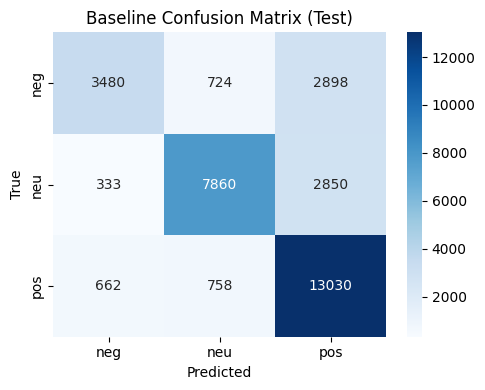

In [9]:
# Baseline: TF-IDF + MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy.sparse import hstack

# as sentiment_score_lemma can be negative, only +ve numerical features passed to chi2/MNB.

preprocess = ColumnTransformer([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1,2),
        min_df=12,
        max_df=0.90,
        sublinear_tf=True,
        strip_accents='unicode'
    ), 'lemmatized_text'),
    ('numerical', 'passthrough', ['word_count','positive_score_lemma','negative_score_lemma'])

])


baseline = Pipeline([
    ('features', preprocess),

    # Apply Chi2 to the combined features (TF-IDF + non-negative numerical)
    # Chi2 requires non-negative input, excluded sentiment_score_lemma in preprocess

    ("chi2", SelectKBest(chi2, k=50000)),
    ('clf', MultinomialNB()) # MultinomialNB also requires non-negative input
])

print('Training baseline...')
baseline.fit(X_train, y_train)

# validation
pred_val = baseline.predict(X_val)
print('\nBaseline (Validation)')
print('Acc:', accuracy_score(y_val, pred_val))
print('Macro-F1:', f1_score(y_val, pred_val, average='macro'))
print(classification_report(y_val, pred_val, digits=4))

# test
pred_test = baseline.predict(X_test)
print('\nBaseline (Test)')
print('Acc:', accuracy_score(y_test, pred_test))
print('Macro-F1:', f1_score(y_test, pred_test, average='macro'))
print(classification_report(y_test, pred_test, digits=4))

# save vectorizer and baseline
import pickle
with open(os.path.join(OUTDIR, 'baseline_pipeline.pkl'), 'wb') as f:
    pickle.dump(baseline, f)

# Generate and save confusion matrix
cm = confusion_matrix(y_test, pred_test)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['neg','neu','pos'], yticklabels=['neg','neu','pos'])
plt.title('Baseline Confusion Matrix (Test)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'baseline_confusion.png'))
plt.show()

Training baseline (text only)...

Baseline (Text Only - Validation)
Acc: 0.7259004724795974
Macro-F1: 0.6928346515526513
              precision    recall  f1-score   support

           0     0.8399    0.4402    0.5776      3551
           1     0.8118    0.6655    0.7314      5521
           2     0.6653    0.9125    0.7695      7225

    accuracy                         0.7259     16297
   macro avg     0.7723    0.6727    0.6928     16297
weighted avg     0.7529    0.7259    0.7148     16297


Baseline (Text Only - Test)
Acc: 0.7259395612824053
Macro-F1: 0.6917450527420481
              precision    recall  f1-score   support

           0     0.8320    0.4359    0.5721      7102
           1     0.8121    0.6668    0.7323     11043
           2     0.6666    0.9136    0.7708     14450

    accuracy                         0.7259     32595
   macro avg     0.7702    0.6721    0.6917     32595
weighted avg     0.7519    0.7259    0.7145     32595



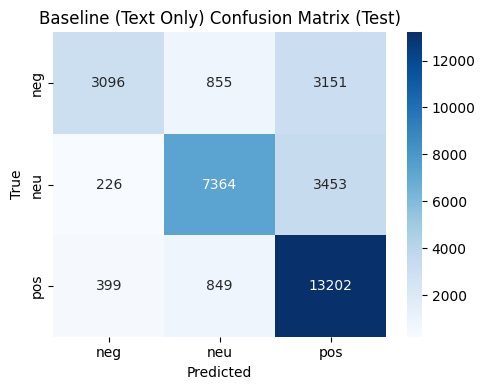

In [10]:
# Baseline: TF-IDF + MultinomialNB (Text only)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, chi2 # Import SelectKBest and chi2

# Preprocessing for text only
preprocess_text_only = ColumnTransformer([
    ('tfidf', TfidfVectorizer(
        ngram_range=(1,2),
        min_df=10,
        max_df=0.90,
        sublinear_tf=True,
        strip_accents='unicode'
    ), 'lemmatized_text') # lemmatized text
], remainder='drop')

baseline_text_only = Pipeline([
    ('features', preprocess_text_only),
    ('clf', MultinomialNB())
])

print('Training baseline (text only)...')
baseline_text_only.fit(X_train, y_train)

# validation
pred_val_text_only = baseline_text_only.predict(X_val)
print('\nBaseline (Text Only - Validation)')
print('Acc:', accuracy_score(y_val, pred_val_text_only))
print('Macro-F1:', f1_score(y_val, pred_val_text_only, average='macro'))
print(classification_report(y_val, pred_val_text_only, digits=4))

# test
pred_test_text_only = baseline_text_only.predict(X_test)
print('\nBaseline (Text Only - Test)')
print('Acc:', accuracy_score(y_test, pred_test_text_only))
print('Macro-F1:', f1_score(y_test, pred_test_text_only, average='macro'))
print(classification_report(y_test, pred_test_text_only, digits=4))

import pickle
with open(os.path.join(OUTDIR, 'baseline_text_only_pipeline.pkl'), 'wb') as f:
    pickle.dump(baseline_text_only, f)

cm_text_only = confusion_matrix(y_test, pred_test_text_only)
plt.figure(figsize=(5,4))
sns.heatmap(cm_text_only, annot=True, fmt='d', cmap='Blues', xticklabels=['neg','neu','pos'], yticklabels=['neg','neu','pos'])
plt.title('Baseline (Text Only) Confusion Matrix (Test)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'baseline_text_only_confusion.png'))
plt.show()

In terms of precision the text only version performs better, and baseline model with hand crafted features works slightly better on accuracy, recall and F1-score

# **BiLSTM**

In [11]:
# from sklearn.model_selection import train_test_split

# X_train, X_temp, y_train, y_temp = train_test_split(
#     df["text"], df["y"], test_size=0.30, random_state=RANDOM_SEED, stratify=df["y"]
# )
# X_val, X_test, y_val, y_test = train_test_split(
#     X_temp, y_temp, test_size=2/3, random_state=RANDOM_SEED, stratify=y_temp
# )
# # Result: ~70% train, 10% val, 20% test

# print(len(X_train), len(X_val), len(X_test))

Class weights: {0: np.float64(1.529830631210524), 1: np.float64(0.9839064400113845), 2: np.float64(0.7518932278793871)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 64, 128)   │  5,120,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     98,816 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 131)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,448 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 3)         │        195 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,227,459 (19.94 MB)

 Trainable params: 5,227,459 (19.94 MB)

 Non-trainable params: 0 (0.00 B)

Training BiLSTM model with features...
Epoch 1/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 14s 19ms/step - accuracy: 0.4262 - loss: 1.3928 - val_accuracy: 0.7601 - val_loss: 0.6244
Epoch 2/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.8049 - loss: 0.5603 - val_accuracy: 0.8687 - val_loss: 0.3746
Epoch 3/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9109 - loss: 0.2887 - val_accuracy: 0.8983 - val_loss: 0.2908
Epoch 4/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9320 - loss: 0.2239 - val_accuracy: 0.8989 - val_loss: 0.3051
Epoch 5/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.9442 - loss: 0.1875 - val_accuracy: 0.8986 - val_loss: 0.3178
Epoch 6/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9504 - loss: 0.1654 - val_accuracy: 0.8989 - val_loss: 0.3327
Epoch 7/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9560 - loss: 0.1452 - val_accuracy: 0.9042 - val_loss: 0.3328
Epoch 8/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - ac

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

BiLSTM Model with Features (Test)
Acc: 0.9009357263383955
Macro-F1: 0.8934901577339248
              precision    recall  f1-score   support

           0     0.8084    0.8774    0.8415      7102
           1     0.9502    0.9050    0.9270     11043
           2     0.9145    0.9094    0.9120     14450

    accuracy                         0.9009     32595
   macro avg     0.8910    0.8973    0.8935     32595
weighted avg     0.9035    0.9009    0.9017     32595



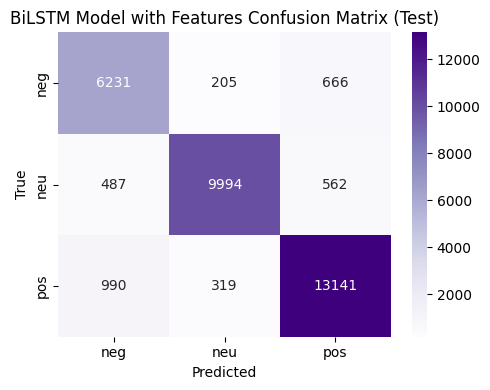

In [12]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pickle
import os

VOCAB_SIZE = 40000
MAX_LEN = 64

tokenizer_bilstm_features = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer_bilstm_features.fit_on_texts(X_train['lemmatized_text']) # Use lemmatized text for tokenizer

def vectorize_texts_bilstm(texts):
    seqs = tokenizer_bilstm_features.texts_to_sequences(texts)
    return keras.preprocessing.sequence.pad_sequences(seqs, maxlen=MAX_LEN, padding='post', truncating='post')

# Prepare text data
Xtr_text_bilstm = vectorize_texts_bilstm(X_train['lemmatized_text'])
Xva_text_bilstm = vectorize_texts_bilstm(X_val['lemmatized_text'])
Xte_text_bilstm = vectorize_texts_bilstm(X_test['lemmatized_text'])

# Prepare numerical features
numerical_features_cols_bilstm = ['word_count', 'positive_score_lemma', 'negative_score_lemma'] # Exclude sentiment_score_lemma due to negative values
Xtr_num_bilstm = X_train[numerical_features_cols_bilstm].values
Xva_num_bilstm = X_val[numerical_features_cols_bilstm].values
Xte_num_bilstm = X_test[numerical_features_cols_bilstm].values

# one-hot (categorical) labels
lb_bilstm_features = LabelBinarizer()
ytr_bilstm_features = lb_bilstm_features.fit_transform(y_train)
yva_bilstm_features = lb_bilstm_features.transform(y_val)
yte_bilstm_features = lb_bilstm_features.transform(y_test)


# Build BiLSTM model with multiple inputs
classes_bilstm_features = np.unique(y_train)
cw_bilstm_features = compute_class_weight('balanced', classes=classes_bilstm_features, y=y_train)
class_weights_bilstm_features = {i: w for i,w in enumerate(cw_bilstm_features)}
print('Class weights:', class_weights_bilstm_features)

def build_bilstm_with_features(vocab_size=VOCAB_SIZE, emb_dim=128, max_len=MAX_LEN, num_classes=3, num_numerical_features=len(numerical_features_cols_bilstm)):
    # Text input branch
    text_inputs = keras.Input(shape=(max_len,), dtype='int32', name='text_input')
    x = layers.Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len)(text_inputs)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dropout(0.5)(x)

    # Numerical features input branch
    numerical_inputs = keras.Input(shape=(num_numerical_features,), dtype='float32', name='numerical_input')

    # Concatenate branches
    combined = layers.concatenate([x, numerical_inputs])

    # Dense layers for combined features
    y = layers.Dense(64, activation='relu')(combined)
    y = layers.Dropout(0.3)(y)
    outputs = layers.Dense(num_classes, activation='softmax')(y)

    model = keras.Model(inputs=[text_inputs, numerical_inputs], outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_bilstm_features = build_bilstm_with_features()
model_bilstm_features.summary()

callbacks_bilstm_features = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)] # Increased patience

print('Training BiLSTM model with features...')
history_bilstm_features = model_bilstm_features.fit(
    {'text_input': Xtr_text_bilstm, 'numerical_input': Xtr_num_bilstm},
    ytr_bilstm_features,
    validation_data=({'text_input': Xva_text_bilstm, 'numerical_input': Xva_num_bilstm}, yva_bilstm_features),
    epochs=20,
    batch_size=256,
    callbacks=callbacks_bilstm_features,
    class_weight=class_weights_bilstm_features,
    verbose=1
)

# save tokenizer and weights
with open(os.path.join(OUTDIR, 'tokenizer_bilstm_features.pkl'), 'wb') as f:
    pickle.dump(tokenizer_bilstm_features, f)
model_bilstm_features.save(os.path.join(OUTDIR, 'bilstm_model_with_features.h5'))

# Evaluate on test set
probs_bilstm_features = model_bilstm_features.predict({'text_input': Xte_text_bilstm, 'numerical_input': Xte_num_bilstm})
y_pred_bilstm_features = probs_bilstm_features.argmax(axis=1)
y_true_bilstm_features = y_test.values

print('\nBiLSTM Model with Features (Test)')
print('Acc:', accuracy_score(y_true_bilstm_features, y_pred_bilstm_features))
print('Macro-F1:', f1_score(y_true_bilstm_features, y_pred_bilstm_features, average='macro'))
print(classification_report(y_true_bilstm_features, y_pred_bilstm_features, digits=4))

cm_bilstm_features = confusion_matrix(y_true_bilstm_features, y_pred_bilstm_features)
plt.figure(figsize=(5,4))
sns.heatmap(cm_bilstm_features, annot=True, fmt='d', cmap='Purples', xticklabels=['neg','neu','pos'], yticklabels=['neg','neu','pos'])
plt.title('BiLSTM Model with Features Confusion Matrix (Test)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'bilstm_confusion_with_features.png'))
plt.show()

Preparing tokenizer (lemmatized text)...
Class weights: {0: np.float64(1.529830631210524), 1: np.float64(0.9839064400113845), 2: np.float64(0.7518932278793871)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 64, 128)        │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,227,267 (19.94 MB)

 Trainable params: 5,227,267 (19.94 MB)

 Non-trainable params: 0 (0.00 B)

Training BiLSTM (lemmatized text only)...
Epoch 1/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.4879 - loss: 0.9615 - val_accuracy: 0.8227 - val_loss: 0.4631
Epoch 2/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.8682 - loss: 0.3800 - val_accuracy: 0.9021 - val_loss: 0.2916
Epoch 3/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.9284 - loss: 0.2291 - val_accuracy: 0.9100 - val_loss: 0.2724
Epoch 4/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9431 - loss: 0.1843 - val_accuracy: 0.9088 - val_loss: 0.2829
Epoch 5/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9520 - loss: 0.1545 - val_accuracy: 0.9070 - val_loss: 0.2915
Epoch 6/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.9589 - loss: 0.1363 - val_accuracy: 0.9040 - val_loss: 0.3098


1019/1019 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step

BiLSTM (Lemmatized Text Only - Test)
Acc: 0.9117349286700415
Macro-F1: 0.9038380292616915
              precision    recall  f1-score   support

           0     0.8571    0.8506    0.8539      7102
           1     0.9456    0.9269    0.9362     11043
           2     0.9130    0.9302    0.9215     14450

    accuracy                         0.9117     32595
   macro avg     0.9052    0.9026    0.9038     32595
weighted avg     0.9119    0.9117    0.9117     32595



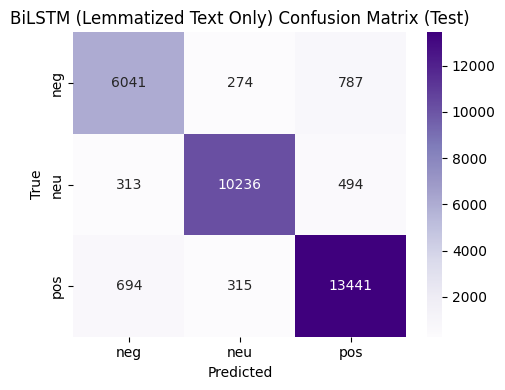

In [13]:
# Neural model: Tokenizer + Embedding + BiLSTM (Keras) - Text only (lemmatized)

VOCAB_SIZE = 40000
MAX_LEN = 64

print('Preparing tokenizer (lemmatized text)...')
tokenizer_bilstm_text_only = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer_bilstm_text_only.fit_on_texts(X_train['lemmatized_text'])

def vectorize_texts_bilstm_text_only(texts):
    seqs = tokenizer_bilstm_text_only.texts_to_sequences(texts)
    return keras.preprocessing.sequence.pad_sequences(seqs, maxlen=MAX_LEN, padding='post', truncating='post')

Xtr_text_only = vectorize_texts_bilstm_text_only(X_train['lemmatized_text'])
Xva_text_only = vectorize_texts_bilstm_text_only(X_val['lemmatized_text'])
Xte_text_only = vectorize_texts_bilstm_text_only(X_test['lemmatized_text'])

# one-hot (categorical) labels
lb_bilstm_text_only = LabelBinarizer()
ytr_bilstm_text_only = lb_bilstm_text_only.fit_transform(y_train)
yva_bilstm_text_only = lb_bilstm_text_only.transform(y_val)
yte_bilstm_text_only = lb_bilstm_text_only.transform(y_test)

# Build model
from sklearn.utils.class_weight import compute_class_weight
classes_bilstm_text_only = np.unique(y_train)
cw_bilstm_text_only = compute_class_weight('balanced', classes=classes_bilstm_text_only, y=y_train)
class_weights_bilstm_text_only = {i: w for i,w in enumerate(cw_bilstm_text_only)}
print('Class weights:', class_weights_bilstm_text_only)


def build_bilstm_text_only(vocab_size=VOCAB_SIZE, emb_dim=128, max_len=MAX_LEN, num_classes=3):
    inputs = keras.Input(shape=(max_len,), dtype='int32')
    x = layers.Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len)(inputs)
    x = layers.Bidirectional(layers.LSTM(64))(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_bilstm_text_only = build_bilstm_text_only()
model_bilstm_text_only.summary()

callbacks_bilstm_text_only = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

print('Training BiLSTM (lemmatized text only)...')
history_bilstm_text_only = model_bilstm_text_only.fit(Xtr_text_only, ytr_bilstm_text_only,
                                                    validation_data=(Xva_text_only, yva_bilstm_text_only),
                                                    epochs=10, batch_size=256,
                                                    callbacks=callbacks_bilstm_text_only,
                                                    class_weight=class_weights_bilstm_text_only,
                                                    verbose=1)

# save tokenizer and weights
with open(os.path.join(OUTDIR, 'tokenizer_bilstm_text_only.pkl'), 'wb') as f:
    pickle.dump(tokenizer_bilstm_text_only, f)
model_bilstm_text_only.save(os.path.join(OUTDIR, 'bilstm_model_text_only.h5'))

# Evaluate on test set
probs_bilstm_text_only = model_bilstm_text_only.predict(Xte_text_only)
y_pred_bilstm_text_only = probs_bilstm_text_only.argmax(axis=1)
y_true_bilstm_text_only = y_test.values

print('\nBiLSTM (Lemmatized Text Only - Test)')
print('Acc:', accuracy_score(y_true_bilstm_text_only, y_pred_bilstm_text_only))
print('Macro-F1:', f1_score(y_true_bilstm_text_only, y_pred_bilstm_text_only, average='macro'))
print(classification_report(y_true_bilstm_text_only, y_pred_bilstm_text_only, digits=4))

cm_bilstm_text_only = confusion_matrix(y_true_bilstm_text_only, y_pred_bilstm_text_only)
plt.figure(figsize=(5,4))
sns.heatmap(cm_bilstm_text_only, annot=True, fmt='d', cmap='Purples', xticklabels=['neg','neu','pos'], yticklabels=['neg','neu','pos'])
plt.title('BiLSTM (Lemmatized Text Only) Confusion Matrix (Test)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'bilstm_confusion_text_only.png'))
plt.show()

# **GRU**

Preparing tokenizer (lemmatized text)...
Class weights: {0: np.float64(1.529830631210524), 1: np.float64(0.9839064400113845), 2: np.float64(0.7518932278793871)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 64, 128)        │     5,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,161,603 (19.69 MB)

 Trainable params: 5,161,603 (19.69 MB)

 Non-trainable params: 0 (0.00 B)

Training GRU (lemmatized text only)...
Epoch 1/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 13ms/step - accuracy: 0.3490 - loss: 1.0981 - val_accuracy: 0.2179 - val_loss: 1.1008
Epoch 2/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.3268 - loss: 1.0973 - val_accuracy: 0.2179 - val_loss: 1.1008
Epoch 3/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3324 - loss: 1.0983 - val_accuracy: 0.4433 - val_loss: 1.0980
Epoch 4/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.3179 - loss: 1.1007 - val_accuracy: 0.4433 - val_loss: 1.0979
Epoch 5/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.3535 - loss: 1.0977 - val_accuracy: 0.4433 - val_loss: 1.0985
Epoch 6/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.3500 - loss: 1.0982 - val_accuracy: 0.2179 - val_loss: 1.1002
Epoch 7/10
446/446 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.3170 - loss: 1.0986 - val_accuracy: 0.2179 - val_loss: 1.1008


1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

GRU (Lemmatized Text Only - Test)
Acc: 0.443319527534898
Macro-F1: 0.20476848407553053
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000      7102
           1     0.0000    0.0000    0.0000     11043
           2     0.4433    1.0000    0.6143     14450

    accuracy                         0.4433     32595
   macro avg     0.1478    0.3333    0.2048     32595
weighted avg     0.1965    0.4433    0.2723     32595



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


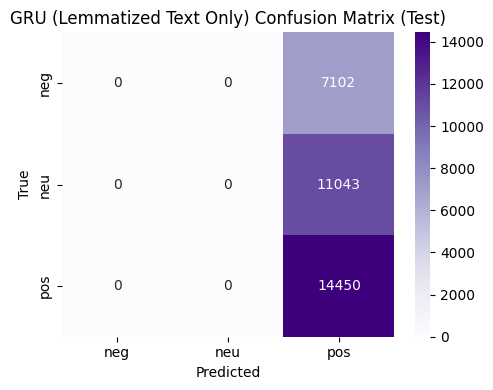

In [14]:
# Neural model: Tokenizer + Embedding + GRU (Keras) - Text only (lemmatized)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pickle
import os

VOCAB_SIZE = 40000
MAX_LEN = 64

print('Preparing tokenizer (lemmatized text)...')
tokenizer_gru_text_only = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer_gru_text_only.fit_on_texts(X_train['lemmatized_text'])

def vectorize_texts_gru_text_only(texts):
    seqs = tokenizer_gru_text_only.texts_to_sequences(texts)
    return keras.preprocessing.sequence.pad_sequences(seqs, maxlen=MAX_LEN, padding='post', truncating='post')

Xtr_text_only_gru = vectorize_texts_gru_text_only(X_train['lemmatized_text'])
Xva_text_only_gru = vectorize_texts_gru_text_only(X_val['lemmatized_text'])
Xte_text_only_gru = vectorize_texts_gru_text_only(X_test['lemmatized_text'])

# one-hot (categorical) labels
lb_gru_text_only = LabelBinarizer()
ytr_gru_text_only = lb_gru_text_only.fit_transform(y_train)
yva_gru_text_only = lb_gru_text_only.transform(y_val)
yte_gru_text_only = lb_gru_text_only.transform(y_test)

# Build model
classes_gru_text_only = np.unique(y_train)
cw_gru_text_only = compute_class_weight('balanced', classes=classes_gru_text_only, y=y_train)
class_weights_gru_text_only = {i: w for i,w in enumerate(cw_gru_text_only)}
print('Class weights:', class_weights_gru_text_only)


def build_gru_text_only(vocab_size=VOCAB_SIZE, emb_dim=128, max_len=MAX_LEN, num_classes=3):
    inputs = keras.Input(shape=(max_len,), dtype='int32')
    x = layers.Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len)(inputs)
    x = layers.GRU(64)(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_gru_text_only = build_gru_text_only()
model_gru_text_only.summary()

callbacks_gru_text_only = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]

print('Training GRU (lemmatized text only)')
history_gru_text_only = model_gru_text_only.fit(Xtr_text_only_gru, ytr_gru_text_only,
                                                validation_data=(Xva_text_only_gru, yva_gru_text_only),
                                                epochs=10, batch_size=256,
                                                callbacks=callbacks_gru_text_only,
                                                class_weight=class_weights_gru_text_only,
                                                verbose=1)

# save tokenizer and weights
with open(os.path.join(OUTDIR, 'tokenizer_gru_text_only.pkl'), 'wb') as f:
    pickle.dump(tokenizer_gru_text_only, f)
model_gru_text_only.save(os.path.join(OUTDIR, 'gru_model_text_only.h5'))

# Evaluate on test set
probs_gru_text_only = model_gru_text_only.predict(Xte_text_only_gru)
y_pred_gru_text_only = probs_gru_text_only.argmax(axis=1)
y_true_gru_text_only = y_test.values

print('\nGRU (Lemmatized Text Only - Test)')
print('Acc:', accuracy_score(y_true_gru_text_only, y_pred_gru_text_only))
print('Macro-F1:', f1_score(y_true_gru_text_only, y_pred_gru_text_only, average='macro'))
print(classification_report(y_true_gru_text_only, y_pred_gru_text_only, digits=4))

cm_gru_text_only = confusion_matrix(y_true_gru_text_only, y_pred_gru_text_only)
plt.figure(figsize=(5,4))
sns.heatmap(cm_gru_text_only, annot=True, fmt='d', cmap='Purples', xticklabels=['neg','neu','pos'], yticklabels=['neg','neu','pos'])
plt.title('GRU (Lemmatized Text Only) Confusion Matrix (Test)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'gru_confusion_text_only.png'))
plt.show()

Preparing tokenizer...
Class weights: {0: np.float64(1.529830631210524), 1: np.float64(0.9839064400113845), 2: np.float64(0.7518932278793871)}


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 64)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 64, 128)   │  5,120,000 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ (None, 64)        │     37,248 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ gru_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ numerical_input     │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 67)        │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ numerical_input[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      4,352 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 64)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 3)         │        195 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,161,795 (19.69 MB)

 Trainable params: 5,161,795 (19.69 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - accuracy: 0.3715 - loss: 1.7631 - val_accuracy: 0.4514 - val_loss: 1.0212
Epoch 2/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.4611 - loss: 1.0452 - val_accuracy: 0.4355 - val_loss: 1.0190
Epoch 3/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4671 - loss: 1.0196 - val_accuracy: 0.4484 - val_loss: 1.0169
Epoch 4/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4729 - loss: 1.0106 - val_accuracy: 0.4685 - val_loss: 1.0017
Epoch 5/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.4890 - loss: 1.0010 - val_accuracy: 0.4820 - val_loss: 0.9825
Epoch 6/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5009 - loss: 0.9884 - val_accuracy: 0.4911 - val_loss: 0.9718
Epoch 7/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.5010 - loss: 0.9818 - val_accuracy: 0.5003 - val_loss: 0.9622
Epoch 8/20
446/446 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.5172 - loss: 0.9645 - val_accu

1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

GRU Model with Features (Test)
Acc: 0.9195888940021476
Macro-F1: 0.9134963537148537
              precision    recall  f1-score   support

           0     0.8311    0.9189    0.8728      7102
           1     0.9446    0.9283    0.9364     11043
           2     0.9500    0.9133    0.9313     14450

    accuracy                         0.9196     32595
   macro avg     0.9086    0.9202    0.9135     32595
weighted avg     0.9223    0.9196    0.9203     32595



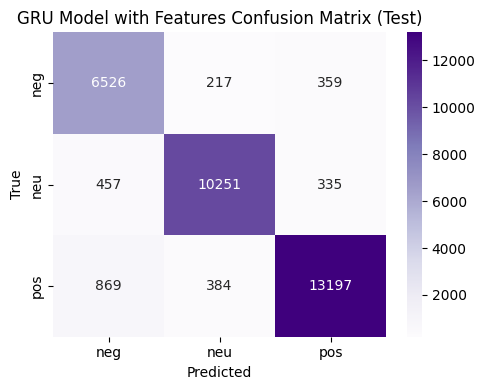

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

VOCAB_SIZE = 40000
MAX_LEN = 64

print('Preparing tokenizer...')
tokenizer_nn = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token='<OOV>')
tokenizer_nn.fit_on_texts(X_train['lemmatized_text']) # Use lemmatized text for tokenizer

def vectorize_texts(texts):
    seqs = tokenizer_nn.texts_to_sequences(texts)
    return keras.preprocessing.sequence.pad_sequences(seqs, maxlen=MAX_LEN, padding='post', truncating='post')

# Prepare text data
Xtr_text = vectorize_texts(X_train['lemmatized_text'])
Xva_text = vectorize_texts(X_val['lemmatized_text'])
Xte_text = vectorize_texts(X_test['lemmatized_text'])

numerical_features_cols = ['word_count', 'positive_score_lemma', 'negative_score_lemma'] # Exclude sentiment_score_lemma due to negative values for now
Xtr_num = X_train[numerical_features_cols].values
Xva_num = X_val[numerical_features_cols].values
Xte_num = X_test[numerical_features_cols].values

# one-hot (categorical) labels
lb_nn = LabelBinarizer()
ytr_nn = lb_nn.fit_transform(y_train)
yva_nn = lb_nn.transform(y_val)
yte_nn = lb_nn.transform(y_test)

# Build model with multiple inputs
classes = np.unique(y_train)
cw_nn = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights_nn = {i: w for i,w in enumerate(cw_nn)}
print('Class weights:', class_weights_nn)

def build_gru_with_features(vocab_size=VOCAB_SIZE, emb_dim=128, max_len=MAX_LEN, num_classes=3, num_numerical_features=len(numerical_features_cols)):
    # Text input branch
    text_inputs = keras.Input(shape=(max_len,), dtype='int32', name='text_input')
    x = layers.Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=max_len)(text_inputs)
    x = layers.GRU(64)(x) # Using GRU layer
    x = layers.Dropout(0.5)(x)

    # Numerical features input branch
    numerical_inputs = keras.Input(shape=(num_numerical_features,), dtype='float32', name='numerical_input')

    # Concatenate branches
    combined = layers.concatenate([x, numerical_inputs])

    # Dense layers for combined features
    y = layers.Dense(64, activation='relu')(combined)
    y = layers.Dropout(0.3)(y)
    outputs = layers.Dense(num_classes, activation='softmax')(y)

    model = keras.Model(inputs=[text_inputs, numerical_inputs], outputs=outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=3e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model_gru = build_gru_with_features()
model_gru.summary()

callbacks_nn = [keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)] # Increased patience

history_gru = model_gru.fit(
    {'text_input': Xtr_text, 'numerical_input': Xtr_num},
    ytr_nn,
    validation_data=({'text_input': Xva_text, 'numerical_input': Xva_num}, yva_nn),
    epochs=20,
    batch_size=256,
    callbacks=callbacks_nn,
    class_weight=class_weights_nn,
    verbose=1
)

# save tokenizer and weights
import pickle
with open(os.path.join(OUTDIR, 'tokenizer_gru.pkl'), 'wb') as f:
    pickle.dump(tokenizer_nn, f)
model_gru.save(os.path.join(OUTDIR, 'gru_model_with_features.h5'))

# Evaluate on test set
probs_gru = model_gru.predict({'text_input': Xte_text, 'numerical_input': Xte_num})
y_pred_gru = probs_gru.argmax(axis=1)
y_true_gru = y_test.values

print('\nGRU Model with Features (Test)')
print('Acc:', accuracy_score(y_true_gru, y_pred_gru))
print('Macro-F1:', f1_score(y_true_gru, y_pred_gru, average='macro'))
print(classification_report(y_true_gru, y_pred_gru, digits=4))

cm_gru = confusion_matrix(y_true_gru, y_pred_gru)
plt.figure(figsize=(5,4))
sns.heatmap(cm_gru, annot=True, fmt='d', cmap='Purples', xticklabels=['neg','neu','pos'], yticklabels=['neg','neu','pos'])
plt.title('GRU Model with Features Confusion Matrix (Test)')
plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout()
plt.savefig(os.path.join(OUTDIR, 'gru_confusion_with_features.png'))
plt.show()

# **Performance Evaluation**

3566/3566 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step
510/510 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step
3566/3566 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step
510/510 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
3566/3566 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
3566/3566 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
510/510 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
--- Model Performance Summary Table ---


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model,Set,Accuracy,F1 Micro,F1 Macro,Precision Macro,Recall Macro,Error Rate
0,Baseline (TF-IDF + NB),Train,0.7952,0.7952,0.7736,0.8144,0.7561,0.2048
1,Baseline (TF-IDF + NB),Validation,0.7468,0.7468,0.7190,0.7710,0.7011,0.2532
2,Baseline (TF-IDF + NB),Test,0.7477,0.7477,0.7189,0.7710,0.7012,0.2523
3,Baseline (Text Only - TF-IDF),Train,0.7994,0.7994,0.7781,0.8360,0.7568,0.2006
4,Baseline (Text Only - TF-IDF),Validation,0.7259,0.7259,0.6928,0.7723,0.6727,0.2741
5,Baseline (Text Only - TF-IDF),Test,0.7259,0.7259,0.6917,0.7702,0.6721,0.2741
6,Original BiLSTM (Text Only),Train,0.9515,0.9515,0.9480,0.9482,0.9479,0.0485
7,Original BiLSTM (Text Only),Validation,0.9100,0.9100,0.9019,0.9042,0.8998,0.0900
8,Original BiLSTM (Text Only),Test,0.9117,0.9117,0.9038,0.9052,0.9026,0.0883
9,BiLSTM with Features,Train,0.9423,0.9423,0.9376,0.9345,0.9419,0.0577



--- Analysis ---
Comparison based on Test Macro-F1:
  Baseline (TF-IDF + NB): 0.7189
  Baseline (Text Only - TF-IDF): 0.6917
  Original BiLSTM (Text Only): 0.9038
  BiLSTM with Features: 0.8935
  GRU with Features: 0.9135
  GRU (Text Only): 0.2048

The GRU with Features model performs best on the test set based on Macro-F1 score (0.9135).
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Generating ROC Curve...


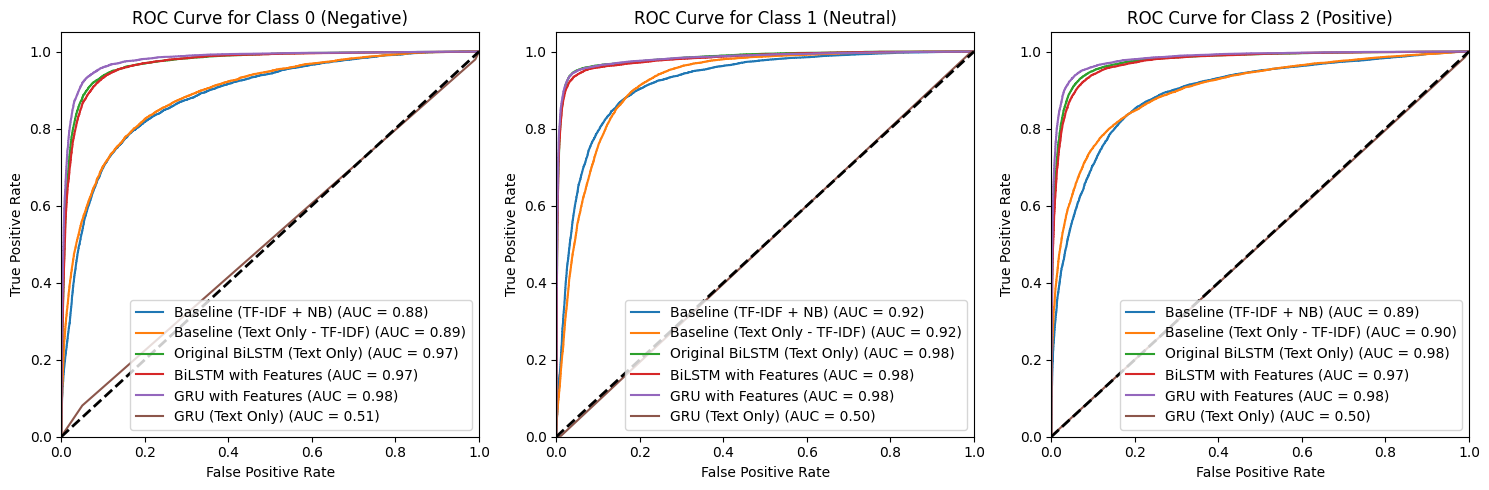

In [16]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Calculate predictions for all models on train, validation, and test sets
baseline_train_preds = baseline.predict(X_train)
baseline_val_preds = pred_val
baseline_test_preds = pred_test

# Baseline Text Only predictions
baseline_text_only_train_preds = baseline_text_only.predict(X_train)
baseline_text_only_val_preds = pred_val_text_only
baseline_text_only_test_preds = pred_test_text_only

# Original BiLSTM predictions
Xtr_text_only_bilstm_eval = vectorize_texts_bilstm_text_only(X_train['lemmatized_text'])
Xva_text_only_bilstm_eval = vectorize_texts_bilstm_text_only(X_val['lemmatized_text'])
Xte_text_only_bilstm_eval = vectorize_texts_bilstm_text_only(X_test['lemmatized_text'])

probs_train_bilstm_text_only = model_bilstm_text_only.predict(Xtr_text_only_bilstm_eval)
y_pred_bilstm_text_only_train = probs_train_bilstm_text_only.argmax(axis=1)
probs_val_bilstm_text_only = model_bilstm_text_only.predict(Xva_text_only_bilstm_eval)
y_pred_bilstm_text_only_val = probs_val_bilstm_text_only.argmax(axis=1)
probs_test_bilstm_text_only = model_bilstm_text_only.predict(Xte_text_only_bilstm_eval)
y_pred_bilstm_text_only_test = probs_test_bilstm_text_only.argmax(axis=1)


# BiLSTM with Features predictions
Xtr_text_bilstm_eval = vectorize_texts_bilstm(X_train['lemmatized_text'])
Xva_text_bilstm_eval = vectorize_texts_bilstm(X_val['lemmatized_text'])
Xte_text_bilstm_eval = vectorize_texts_bilstm(X_test['lemmatized_text'])

numerical_features_cols_bilstm_eval = ['word_count', 'positive_score_lemma', 'negative_score_lemma']
Xtr_num_bilstm_eval = X_train[numerical_features_cols_bilstm_eval].values
Xva_num_bilstm_eval = X_val[numerical_features_cols_bilstm_eval].values
Xte_num_bilstm_eval = X_test[numerical_features_cols_bilstm_eval].values

probs_train_bilstm_features = model_bilstm_features.predict({'text_input': Xtr_text_bilstm_eval, 'numerical_input': Xtr_num_bilstm_eval})
y_pred_bilstm_features_train = probs_train_bilstm_features.argmax(axis=1)
probs_val_bilstm_features = model_bilstm_features.predict({'text_input': Xva_text_bilstm_eval, 'numerical_input': Xva_num_bilstm_eval})
y_pred_bilstm_features_val = probs_val_bilstm_features.argmax(axis=1)
probs_test_bilstm_features = model_bilstm_features.predict({'text_input': Xte_text_bilstm_eval, 'numerical_input': Xte_num_bilstm_eval})
y_pred_bilstm_features_test = probs_test_bilstm_features.argmax(axis=1)


# GRU with Features predictions
Xtr_text_gru_eval = vectorize_texts(X_train['lemmatized_text'])
Xva_text_gru_eval = vectorize_texts(X_val['lemmatized_text'])
Xte_text_gru_eval = vectorize_texts(X_test['lemmatized_text'])

numerical_features_cols_gru_eval = ['word_count', 'positive_score_lemma', 'negative_score_lemma']
Xtr_num_gru_eval = X_train[numerical_features_cols_gru_eval].values
Xva_num_gru_eval = X_val[numerical_features_cols_gru_eval].values
Xte_num_gru_eval = X_test[numerical_features_cols_gru_eval].values

probs_train_gru = model_gru.predict({'text_input': Xtr_text_gru_eval, 'numerical_input': Xtr_num_gru_eval})
y_pred_gru_train = probs_train_gru.argmax(axis=1)
probs_val_gru = model_gru.predict({'text_input': Xva_text_gru_eval, 'numerical_input': Xva_num_gru_eval})
y_pred_gru_val = probs_val_gru.argmax(axis=1)
probs_test_gru = model_gru.predict({'text_input': Xte_text_gru_eval, 'numerical_input': Xte_num_gru_eval})
y_pred_gru_test = probs_test_gru.argmax(axis=1)


# GRU Text Only predictions (assuming model_gru_text_only exists from previous cell)
probs_train_gru_text_only = model_gru_text_only.predict(Xtr_text_only_gru)
y_pred_gru_text_only_train = probs_train_gru_text_only.argmax(axis=1)
probs_val_gru_text_only = model_gru_text_only.predict(Xva_text_only_gru)
y_pred_gru_text_only_val = probs_val_gru_text_only.argmax(axis=1)
probs_test_gru_text_only = model_gru_text_only.predict(Xte_text_only_gru)
y_pred_gru_text_only_test = probs_test_gru_text_only.argmax(axis=1)


def calculate_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')
    precision_macro = precision_score(y_true, y_pred, average='macro')
    recall_macro = recall_score(y_true, y_pred, average='macro')
    error_rate = 1 - acc
    return acc, f1_micro, f1_macro, precision_macro, recall_macro, error_rate

metrics_data = []

# Baseline (TF-IDF + NB)
metrics_data.append({
    'Model': 'Baseline (TF-IDF + NB)',
    'Set': 'Train', **dict(zip(['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate'], calculate_metrics(y_train, baseline_train_preds)))
})
metrics_data.append({
    'Model': 'Baseline (TF-IDF + NB)',
    'Set': 'Validation', **dict(zip(['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate'], calculate_metrics(y_val, baseline_val_preds)))
})
metrics_data.append({
    'Model': 'Baseline (TF-IDF + NB)',
    'Set': 'Test', **dict(zip(['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate'], calculate_metrics(y_test, baseline_test_preds)))
})

# Baseline (Text Only - TF-IDF)
metrics_data.append({
    'Model': 'Baseline (Text Only - TF-IDF)',
    'Set': 'Train', **dict(zip(['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate'], calculate_metrics(y_train, baseline_text_only_train_preds)))
})
metrics_data.append({
    'Model': 'Baseline (Text Only - TF-IDF)',
    'Set': 'Validation', **dict(zip(['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate'], calculate_metrics(y_val, baseline_text_only_val_preds)))
})
metrics_data.append({
    'Model': 'Baseline (Text Only - TF-IDF)',
    'Set': 'Test', **dict(zip(['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate'], calculate_metrics(y_test, baseline_text_only_test_preds)))
})


# Original BiLSTM (Text Only)
metrics_data.append({
    'Model': 'Original BiLSTM (Text Only)',
    'Set': 'Train', **dict(zip(['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate'], calculate_metrics(y_train, y_pred_bilstm_text_only_train)))
})
metrics_data.append({
    'Model': 'Original BiLSTM (Text Only)',
    'Set': 'Validation', **dict(zip(['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate'], calculate_metrics(y_val, y_pred_bilstm_text_only_val)))
})
metrics_data.append({
    'Model': 'Original BiLSTM (Text Only)',
    'Set': 'Test', **dict(zip(['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate'], calculate_metrics(y_test, y_pred_bilstm_text_only_test)))
})

# BiLSTM with Features
metrics_data.append({
    'Model': 'BiLSTM with Features',
    'Set': 'Train', **dict(zip(['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate'], calculate_metrics(y_train, y_pred_bilstm_features_train)))
})
metrics_data.append({
    'Model': 'BiLSTM with Features',
    'Set': 'Validation', **dict(zip(['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate'], calculate_metrics(y_val, y_pred_bilstm_features_val)))
})
metrics_data.append({
    'Model': 'BiLSTM with Features',
    'Set': 'Test', **dict(zip(['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate'], calculate_metrics(y_test, y_pred_bilstm_features_test)))
})

# GRU with Features
metrics_data.append({
    'Model': 'GRU with Features',
    'Set': 'Train', **dict(zip(['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate'], calculate_metrics(y_train, y_pred_gru_train)))
})
metrics_data.append({
    'Model': 'GRU with Features',
    'Set': 'Validation', **dict(zip(['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate'], calculate_metrics(y_val, y_pred_gru_val)))
})
metrics_data.append({
    'Model': 'GRU with Features',
    'Set': 'Test', **dict(zip(['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate'], calculate_metrics(y_test, y_pred_gru_test)))
})

# GRU Text Only
metrics_data.append({
    'Model': 'GRU (Text Only)',
    'Set': 'Train', **dict(zip(['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate'], calculate_metrics(y_train, y_pred_gru_text_only_train)))
})
metrics_data.append({
    'Model': 'GRU (Text Only)',
    'Set': 'Validation', **dict(zip(['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate'], calculate_metrics(y_val, y_pred_gru_text_only_val)))
})
metrics_data.append({
    'Model': 'GRU (Text Only)',
    'Set': 'Test', **dict(zip(['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate'], calculate_metrics(y_test, y_pred_gru_text_only_test)))
})


performance_df = pd.DataFrame(metrics_data)

print("--- Model Performance Summary Table ---")
display(performance_df.round(4))


test_performance = performance_df[performance_df['Set'] == 'Test'].copy()
best_model_row = test_performance.loc[test_performance['F1 Macro'].idxmax()]
best_model_name = best_model_row['Model']
best_f1_macro = best_model_row['F1 Macro']

print('\n--- Analysis ---')
print('Comparison based on Test Macro-F1:')
print(f'  Baseline (TF-IDF + NB): {test_performance[test_performance["Model"] == "Baseline (TF-IDF + NB)"]["F1 Macro"].values[0]:.4f}')
print(f'  Baseline (Text Only - TF-IDF): {test_performance[test_performance["Model"] == "Baseline (Text Only - TF-IDF)"]["F1 Macro"].values[0]:.4f}')
print(f'  Original BiLSTM (Text Only): {test_performance[test_performance["Model"] == "Original BiLSTM (Text Only)"]["F1 Macro"].values[0]:.4f}')
print(f'  BiLSTM with Features: {test_performance[test_performance["Model"] == "BiLSTM with Features"]["F1 Macro"].values[0]:.4f}')
print(f'  GRU with Features: {test_performance[test_performance["Model"] == "GRU with Features"]["F1 Macro"].values[0]:.4f}')
print(f'  GRU (Text Only): {test_performance[test_performance["Model"] == "GRU (Text Only)"]["F1 Macro"].values[0]:.4f}')


print(f'\nThe {best_model_name} model performs best on the test set based on Macro-F1 score ({best_f1_macro:.4f}).')

# Generate and plot ROC curves for all models
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

# Get probability predictions for all models
baseline_test_probs = baseline.predict_proba(X_test)
baseline_text_only_test_probs = baseline_text_only.predict_proba(X_test)
bilstm_text_only_test_probs = model_bilstm_text_only.predict(Xte_text_only_bilstm_eval)
bilstm_features_test_probs = model_bilstm_features.predict({'text_input': Xte_text_bilstm_eval, 'numerical_input': Xte_num_bilstm_eval})
gru_features_test_probs = model_gru.predict({'text_input': Xte_text_gru_eval, 'numerical_input': Xte_num_gru_eval})
gru_text_only_test_probs = model_gru_text_only.predict(Xte_text_only_gru)


fpr = {}
tpr = {}
roc_auc = {}

models_probs = {
    'Baseline (TF-IDF + NB)': baseline_test_probs,
    'Baseline (Text Only - TF-IDF)': baseline_text_only_test_probs,
    'Original BiLSTM (Text Only)': bilstm_text_only_test_probs,
    'BiLSTM with Features': bilstm_features_test_probs,
    'GRU with Features': gru_features_test_probs,
    'GRU (Text Only)': gru_text_only_test_probs
}

print('\nGenerating ROC Curve...')
plt.figure(figsize=(15, 5))

for i in range(n_classes):
    plt.subplot(1, n_classes, i + 1)
    for model_name, model_probs in models_probs.items():
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], model_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'{model_name} (AUC = {roc_auc[i]:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Class {i} ({["Negative", "Neutral", "Positive"][i]})')
    plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

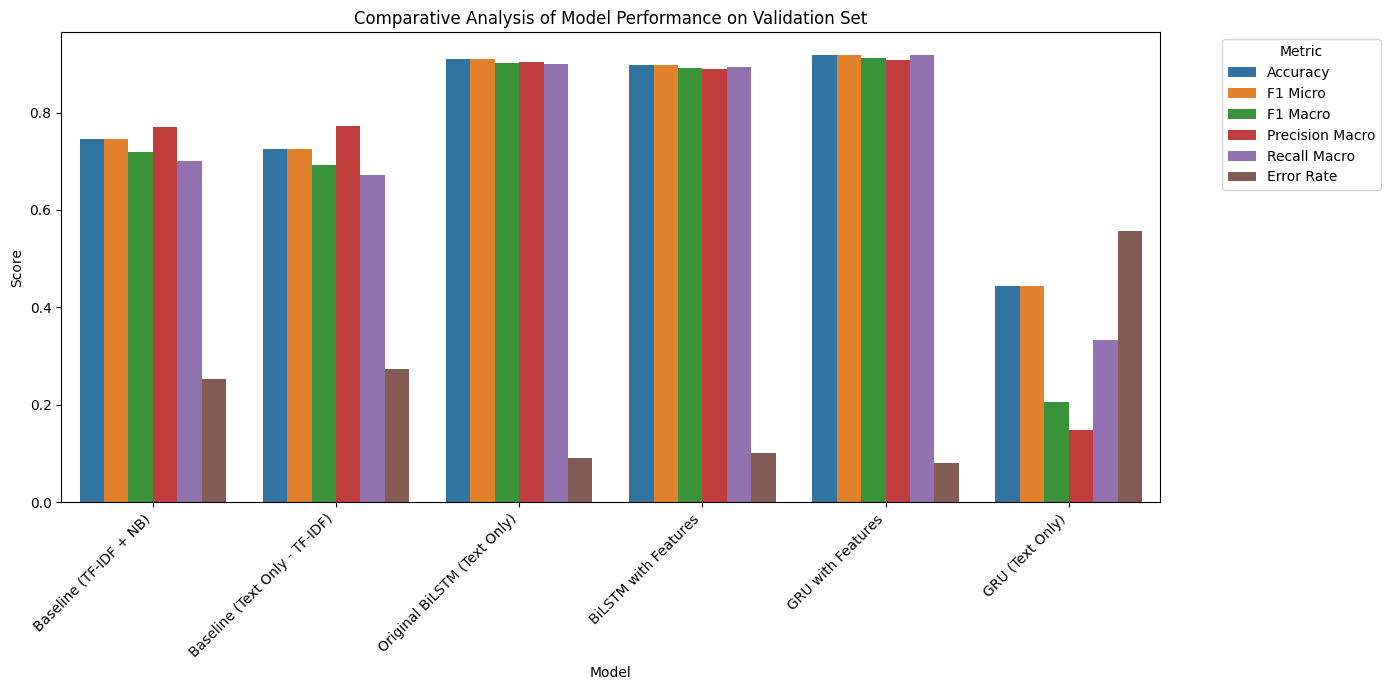

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

val_performance = performance_df[performance_df['Set'] == 'Validation'].copy()
metrics_to_plot = ['Accuracy', 'F1 Micro', 'F1 Macro', 'Precision Macro', 'Recall Macro', 'Error Rate']
performance_melted = val_performance.melt(id_vars='Model', value_vars=metrics_to_plot, var_name='Metric', value_name='Score')
plt.figure(figsize=(14, 7))
sns.barplot(x='Model', y='Score', hue='Metric', data=performance_melted)
plt.title('Comparative Analysis of Model Performance on Validation Set')
plt.ylabel('Score')
plt.xlabel('Model')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# **Error Analysis**

 Error analysis for top 3 performing models

In [22]:
import pandas as pd

# Sort by Macro-F1 on the test set to get top models
test_performance_sorted = performance_df[performance_df['Set'] == 'Test'].sort_values(by='F1 Macro', ascending=False)
top_3_models = test_performance_sorted.head(3)['Model'].tolist()

print("Top 3 models based on Test Macro-F1:", top_3_models)

model_predictions = {
    'Baseline (TF-IDF + NB)': pred_test,
    'Baseline (Text Only - TF-IDF)': pred_test_text_only,
    'Original BiLSTM (Text Only)': y_pred_bilstm_text_only_test,
    'BiLSTM with Features': y_pred_bilstm_features_test,
    'GRU with Features': y_pred_gru_test,
    'GRU (Text Only)': y_pred_gru_text_only_test
}


for model_name in top_3_models:
    print(f'\n--- Error Analysis: {model_name} ---')

    predictions = model_predictions[model_name]
    errors_df = X_test.copy()
    errors_df['true'] = y_test
    errors_df['pred'] = predictions
    misclassified_df = errors_df[errors_df['true'] != errors_df['pred']].copy()

    print(f'Total misclassified by {model_name}: {len(misclassified_df)}')

    # Select at least 6 diverse examples
    picked_list = []
    seen_true_labels = set()

    # Prioritize diverse true labels
    for index, row in misclassified_df.iterrows():
        if row['true'] not in seen_true_labels:
            picked_list.append(row)
            seen_true_labels.add(row['true'])
        if len(picked_list) >= 6 and len(seen_true_labels) == len(y_test.unique()):
            break

    if len(picked_list) < 6:
        remaining_mis = misclassified_df[~misclassified_df.index.isin([row.name for row in picked_list])]

        num_to_sample = min(6 - len(picked_list), len(remaining_mis))
        if num_to_sample > 0:
             picked_list.extend([row for _, row in remaining_mis.sample(num_to_sample, random_state=RANDOM_SEED).iterrows()])


    picked_df = pd.DataFrame(picked_list)

    if picked_df.empty and not misclassified_df.empty:
         picked_df = misclassified_df.sample(min(6, len(misclassified_df)), random_state=RANDOM_SEED)


    picked_df.reset_index(drop=True, inplace=True)

    print(picked_df[['text', 'true', 'pred'] ])

    # Add commentary
    print(f"\n--- Error Analysis Commentary ({model_name}) ---")
    print(f"Here are some potential reasons for misclassification in the selected examples for the {model_name} model:")
    for i, row in picked_df.iterrows():
        print(f"\nExample {i+1}:")
        print(f"  Text: {row['text']}")
        print(f"  True Label: {row['true']} (0: Negative, 1: Neutral, 2: Positive)")
        print(f"  Predicted Label: {row['pred']} (0: Negative, 1: Neutral, 2: Positive)")

        # rule based commentary on the true and predicted labels
        if row['true'] == 0 and row['pred'] == 1:
            print("  Commentary: This negative example was predicted as neutral. The text might contain some ambiguity or lack strong negative indicators, or the features might not strongly indicate negativity.")
        elif row['true'] == 0 and row['pred'] == 2:
             print("  Commentary: This negative example was predicted as positive. This could be due to sarcasm, irony, or complex language that the model struggled with, or the features might incorrectly suggest positivity.")
        elif row['true'] == 1 and row['pred'] == 0:
            print("  Commentary: This neutral example was predicted as negative. The text or features might contain elements sometimes associated with negative sentiment in other contexts.")
        elif row['true'] == 1 and row['pred'] == 2:
            print("  Commentary: This neutral example was predicted as positive. The text or features might contain some positive-leaning elements or be interpreted positively due to context not captured.")
        elif row['true'] == 2 and row['pred'] == 0:
            print("  Commentary: This positive example was predicted as negative. This is likely due to sarcasm, complex structures, or features that incorrectly indicate negativity.")
        elif row['true'] == 2 and row['pred'] == 1:
            print("  Commentary: This positive example was predicted as neutral. The text might not have strong enough positive indicators, or it could contain some neutral elements or features that influenced the prediction.")
        else:
            print("  Commentary: Further analysis is needed to understand the specific reason for this misclassification.")


    save_path = os.path.join(OUTDIR, f'misclassified_examples_{model_name.replace(" ", "_").lower()}.csv')
    picked_df.to_csv(save_path, index=False)
    print(f'\nSaved misclassified examples to {save_path}')

Top 3 models based on Test Macro-F1: ['GRU with Features', 'Original BiLSTM (Text Only)', 'BiLSTM with Features']

--- Error Analysis: GRU with Features ---
Total misclassified by GRU with Features: 2621
                                                text  true  pred
0  modi govt has saved lot money due dbt those mo...     0     1
1  neerav modi arrested london mallya said repay ...     1     0
2  under the strong leadership modi india its eco...     2     0
3  the news crore women missing from voter rolls ...     0     2
4  deliberate otherwise davos modi speak infront ...     2     0
5  modi shah modishah maker disastrously hopeless...     0     1

--- Error Analysis Commentary (GRU with Features) ---
Here are some potential reasons for misclassification in the selected examples for the GRU with Features model:

Example 1:
  Text: modi govt has saved lot money due dbt those money used for various causes some are accounted budget some are not_ just like listed companies stock market 

# **Summary**

- **Data Loading and Preprocessing:**
  
  The dataset was loaded, cleaned (including basic negation handling), and new handcrafted features were added: word count, positive lexicon score (lemmatized), negative lexicon score (lemmatized), and sentiment score (lemmatized). Lemmatization was also applied to the text.
- **Model Performance:**

  We trained and evaluated three models with lemmatized text and crafted fetaures:
  - **Baseline MultinomialNB**
  
  - **BiLSTM**
  
  - **GRU**
  
- **Performance Comparison:**

  - Baseline models performed moderately well but lacked depth in sentiment understanding

  - BiLSTM (Text Only) showed strong performance, effectively capturing contextual patterns

  - Adding features slightly improved model robustness and precision

  - GRU with features achieved the best overall performance, showing balanced accuracy and recall

  -  The ROC curve shows that GRU & BILSTM outperforms the other models

  -  GRU with features achieves the highest F1-score among all models
  
- **Error Analysis:**

    Error analysis was performed for the top 3 models with 6 misclassified examples

# **Conclusion**

-   GRU with features achieved the best overall results, showing the highest accuracy and lowest error rate

- BiLSTM models also performed strongly, especially in precision and consistency across datasets

-  Feature extraction greatly improved the performance of models